In [2]:
import wandb
import pandas as pd

In [3]:
%load_ext autoreload
%autoreload 2

from nb_funcs import (
    get_results_df_for_run, get_review_from_eval_set,
    add_av_prec_to_eval_run, get_wandb_runs_table, make_df_from_wandb_runs,
    get_review_from_model_name
)

fig_dir = '/home/tom/msc/diss/report/latex/figures/'

## Datasets

In [48]:
from pathlib import Path
import numpy as np
from nb_funcs import REVIEW_LABELS

rows = []
for review_dir in Path('.').glob('../data/covidence/review_*'):
    try:
        review_id = int(review_dir.parts[-1].split('_')[1])
    except ValueError:
        continue
    row = {'review': review_id}
    df = pd.read_csv(review_dir / 'full.csv', index_col=0)
    row['size'] = len(df)
    row['pos_items'] = df.label.sum()
    row['support'] = df.label.sum() / len(df)
    try:
        nat_split = np.genfromtxt(review_dir / 'natural_train_split.txt')
    except FileNotFoundError:
        row['natural_split_size'] = None
        row['balanced_split_size'] = None
        row['validation_split_size'] = None
        rows.append(row)
        continue
        
    row['natural_split_size'] = len(nat_split)
    row['natural_split_support'] = df.loc[nat_split].label.sum() / len(nat_split)
    bal_split = np.genfromtxt(review_dir / 'balanced_train_split.txt')
    row['balanced_split_size'] = len(bal_split)
    val_split = np.genfromtxt(review_dir / 'val_split.txt')
    row['validation_split_size'] = len(val_split)
    row['validation_split_pos_items'] = df.loc[val_split].label.sum()
    row['validation_split_support'] = df.loc[val_split].label.sum() / len(val_split)

    row['balanced_train_set_frac'] = len(bal_split) / len(df)

    rows.append(row)

datasets = pd.DataFrame(rows)
datasets['review_label'] = datasets.review.apply(REVIEW_LABELS.get)
datasets = datasets.set_index('review')


In [941]:
datasets.sort_values('pos_items', ascending=False)

,size,pos_items,support,natural_split_size,natural_split_support,balanced_split_size,validation_split_size,validation_split_pos_items,validation_split_support,balanced_train_set_frac,review_label
review,,,,,,,,,,,
121733,3707,1373,0.370380,3150.0,0.374286,2358.0,557.0,194.0,0.348294,0.636094,A
287708,1360,256,0.188235,1156.0,0.182526,422.0,204.0,45.0,0.220588,0.310294,B
165805,2292,239,0.104276,1948.0,0.104209,406.0,344.0,36.0,0.104651,0.177138,C
258698,6976,213,0.030533,5929.0,0.030697,364.0,1047.0,31.0,0.029608,0.052179,D
117787,1330,142,0.106767,1130.0,0.108850,246.0,200.0,19.0,0.095000,0.184962,E
240084,599,130,0.217028,509.0,0.227898,232.0,90.0,14.0,0.155556,0.387312,I
334317,4365,126,0.028866,3710.0,0.029111,216.0,655.0,18.0,0.027481,0.049485,F
378562,643,98,0.152411,546.0,0.163004,178.0,97.0,9.0,0.092784,0.276827,G
288055,1381,26,0.018827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H


In [955]:
from run_common import load_reviews

df = load_reviews()
df['review_label'] = list(map(REVIEW_LABELS.get, df.index))
[print(row.review_label, row.title) for _, row in df.iterrows()]

A Is aerosolised HOCl an effective and safe technological approach for the suppression of airborne viral loads in public spaces?
D The social lives of point-of-care tests in low- and middle-income countries: a qualitative evidence synthesis protocol
E Compact cities and the Covid-19 pandemic: Systematic review of the associations between transmission of Covid-19 or other respiratory viruses and population density or other features of neighbourhood design
B What are the adaptations being implemented to address the health impacts of flooding in LMICs in the tropics and what is known about their effectiveness?
H A systematic review of the effectiveness of heat adaptation measures for urban areas in an oceanic climate
G Impact of the COVID-19 Pandemic and Scottish Public Sector Response on Refugees and Asylum Seekers
F Assessing the implementation, outcomes and impact of national suicide prevention strategies: a systematic review
C Risk of serious COVID-19 outcomes among adults and childre

[None, None, None, None, None, None, None, None, None]

## Zero- and few-shot evaluation

In [4]:
api = wandb.Api()
runs = api.runs('tberm-org/zero-shot-final')
df = make_df_from_wandb_runs([
    run for run in runs
    if ('ignore' not in run.tags) and (run.config['run_config'].get('trunc_dataset', 0) == 300)
    and '121733' in run.config['run_config']['eval_set']
    and ("Llama" in run.config['model'] or "gpt" in run.config['model'])
])

In [5]:
df[df['run_config/num_shots'] == 0][
    ['model', 'average_precision', 'auroc', 'f1', 'precision@95']
]

,model,average_precision,auroc,f1,precision@95
5,Meta-Llama-3-8B-instruct,0.785144,0.867035,0.716049,0.507772
6,gpt-4o,0.847476,0.906700,0.630872,0.333333


In [6]:
df[df['run_config/num_shots'] == 0][
    ['model', 'average_precision', 'auroc', 'f1', 'precision@95']
]

,model,average_precision,auroc,f1,precision@95
5,Meta-Llama-3-8B-instruct,0.785144,0.867035,0.716049,0.507772
6,gpt-4o,0.847476,0.906700,0.630872,0.333333


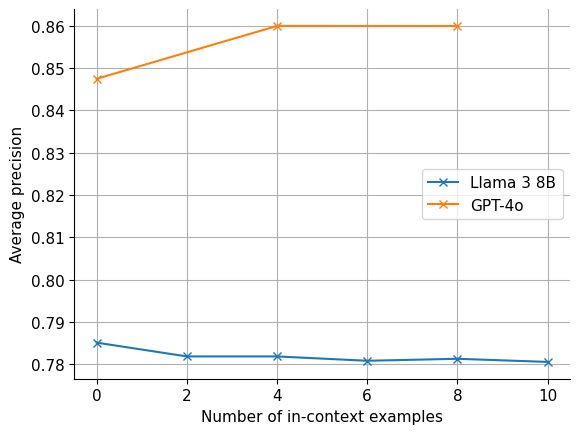

In [58]:
mistral = df[df.model.str.contains('Mistral')].sort_values('run_config/num_shots')
llama = df[df.model.str.contains('Llama')].sort_values('run_config/num_shots')
gpt = df[df.model.str.contains('gpt')].sort_values('run_config/num_shots')

fig, ax = plt.subplots()
#ax.plot(mistral['run_config/num_shots'], mistral.average_precision, '-x', label='Mistral 7B')
ax.plot(llama['run_config/num_shots'], llama.average_precision, '-x', label='Llama 3 8B')
ax.plot(gpt['run_config/num_shots'], gpt.average_precision, '-x', label='GPT-4o')
ax.legend()
ax.set_xlabel('Number of in-context examples')
ax.set_ylabel('Average precision')

fig.savefig(fig_dir + 'icl.pdf')

## Single review fine-tuning

In [498]:
api = wandb.Api()
runs = api.runs('tberm-org/ft-new-reviews')
runs = [run for run in runs
        if 'baseline' not in run.tags
        and 'average_precision' in run.summary]

single_ft_df = make_df_from_wandb_runs(runs)

In [499]:
rows = [
    {
        'name': run.name,
        'id': run.id,
        'train_set': run.config['train_config']['train_set'],
        'eval_set': run.config['run_config']['eval_set'],
        'balanced_train_set': 'balanced' in run.config['train_config']['train_set'],
        'review': get_review_from_eval_set(run.config['run_config']['eval_set']),
        'f1': run.summary['f1'],
        'average_precision': run.summary['average_precision'],
        'acc': run.summary['acc'],
        'precision': run.summary['precision'],
        'recall': run.summary['recall'],
        'contrastive_criteria': '-cc' in run.name,
    }
    for run in runs
]

df = pd.DataFrame(rows)
df = df[~df.contrastive_criteria]


In [501]:
df.groupby(['review', 'balanced_train_set']).agg(
    {'name': ['first', 'count'], 'average_precision': ['min', 'max']}
)

name       average_precision          
                               first count               min       max
review balanced_train_set                                             
117787 False                 amapola     3          0.698029  0.764779
       True                 bluebell     7          0.632671  0.642758
121733 False                clematis     1          0.910289  0.910289
       True                 daffodil     5          0.919678  0.924798
165805 False               narcissus     2          0.732554  0.751899
       True                    poppy     5          0.713160  0.753641
258698 False                geranium     4          0.789543  0.834458
       True                 hyacinth     7          0.790115  0.829423
287708 False                foxglove     1          0.790115  0.790115
       True                edelweiss     7          0.740821  0.921173
334317 False                magnolia     2          0.435898  0.436585
       True                     lily     6          0.359680  0.458599
378562 False                 jasmine     2          0.731776  0.857275
       True                     iris     6          0.768612  0.840123

## Multi-review fine-tuning

In [502]:
# Models fine-tuned on all reviews apart from the evaluation review

api = wandb.Api()
runs = [run for run in api.runs('tberm-org/multi-review-ft')
        if 'average_precision' in run.summary
        and 'three-review' not in run.tags]
multi_ft_df = make_df_from_wandb_runs(runs)

In [503]:
# Models fine-tuned on best three reviews (not including the evaluation review)

api = wandb.Api()
runs = [run for run in api.runs('tberm-org/multi-review-eval')]
three_rev_df = make_df_from_wandb_runs(runs)

In [504]:
# Base model evaluations

api = wandb.Api()
runs = [run for run in api.runs('tberm-org/zero-shot-baselines')]
baseline_df = make_df_from_wandb_runs(runs)

In [505]:
multi_ft_df['eval_review'] = multi_ft_df['run_config/eval_set'].apply(get_review_from_eval_set)

In [506]:
three_rev_df['eval_review'] = three_rev_df['run_config/eval_set'].apply(get_review_from_eval_set)

In [510]:
# Models trained on the evaluation review

single_ft_bal = single_ft_df[single_ft_df['train_config/train_set'].str.contains('balanced')]
single_ft_bal['eval_review'] = single_ft_df['run_config/eval_set'].apply(get_review_from_eval_set)

/tmp/ipykernel_64868/4116973481.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_ft_bal['eval_review'] = single_ft_df['run_config/eval_set'].apply(get_review_from_eval_set)


In [ ]:
three_rev_df[three_rev_df.eval_review == 121733][['name', 'run_config/load_wandb_model', 'average_precision', 'auroc']]

In [512]:
baseline_df['eval_review'] = baseline_df['run_config/eval_set'].apply(get_review_from_eval_set)

In [513]:
rows = []
for review in [121733, 117787, 165805, 258698, 287708, 334317, 378562]:
    row = {'review': review}

    single_ft_nat_runs = single_ft_df[single_ft_df.eval_review == review]
    row['single_ft_nat'] = single_ft_nat_runs['average_precision'].mean()

    single_ft_bal_runs = single_ft_bal[single_ft_bal.eval_review == review]
    row['single_ft_bal'] = single_ft_bal_runs['average_precision'].mean()
    
    multi_ft_runs = multi_ft_df[multi_ft_df.eval_review == review]
    row['multi_ft_df'] = multi_ft_runs['average_precision'].mean()
    
    three_rev_runs = three_rev_df[three_rev_df.eval_review == review]
    row['three_rev_ft'] = three_rev_runs['average_precision'].mean()

    baseline_runs = baseline_df[baseline_df.eval_review == review]
    row['baseline'] = baseline_runs['average_precision'].mean() 
    
    rows.append(row)

df = pd.DataFrame(rows).set_index('review')

AttributeError: 'DataFrame' object has no attribute 'eval_review'

In [170]:
df

,single_ft_nat,single_ft_bal,multi_ft_df,three_rev_ft,baseline
review,,,,,
121733,0.917047,0.920425,0.791489,0.809892,0.796391
117787,0.686541,0.640327,0.651263,0.612291,0.554962
165805,0.733917,0.725608,0.612415,0.588912,0.569701
258698,0.813740,0.810350,0.711532,0.727879,0.576951
287708,0.835980,0.858912,0.743138,0.714898,0.632755
334317,0.426085,0.419314,0.329902,0.347066,0.219931
378562,0.804520,0.778143,0.546674,0.586046,0.533808


<Axes: xlabel='review'>

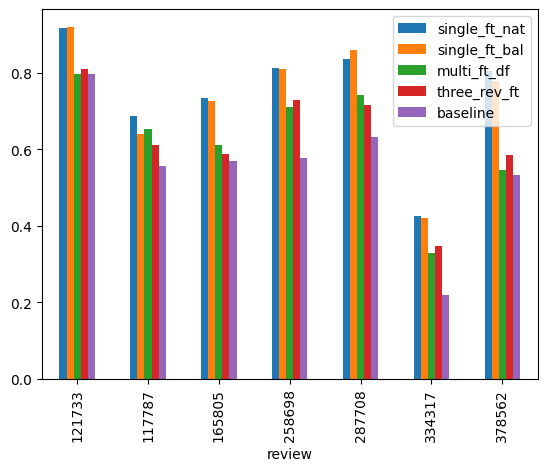

In [186]:
df.plot.bar()

In [189]:
datasets.sort_values('pos_items', ascending=False)

,size,pos_items,natural_split_size,natural_split_support,balanced_split_size,validation_split_size,validation_split_support
review,,,,,,,
121733,3707,1373,3150.0,0.374286,2358.0,557.0,0.348294
287708,1360,256,1156.0,0.182526,422.0,204.0,0.220588
165805,2292,239,1948.0,0.104209,406.0,344.0,0.104651
258698,6976,213,5929.0,0.030697,364.0,1047.0,0.029608
117787,1330,142,1130.0,0.108850,246.0,200.0,0.095000
334317,4365,126,3710.0,0.029111,216.0,655.0,0.027481
378562,643,98,546.0,0.163004,178.0,97.0,0.092784
288055,1381,26,NaN,NaN,NaN,NaN,NaN


### Multi-task vs adapter merging

* There are runs correponding to several different strategies for selecting expert LoRA models, as well as a multi-task learning LoRA model
* For each strategy and held out evaluation review, we have three repeated runs corresponding to different seeds
* Compile average performance scores across seeds for all the strategies into final results csv. 

In [814]:
# Multi-task learning runs

import wandb
from nb_funcs import make_df_from_wandb_runs, get_review_from_eval_set

def is_good_mt_run(run):
    if 'too-short' in run.tags:
        return False
    if run.config['run_config']['trunc_dataset'] is not None:
        return False
    eval_set = run.config['run_config']['eval_set'].split('/')[-1]
    if eval_set not in ('full.csv', 'trunc_full.txt', 'nat_few_shot_complement.txt'):
        return False
    return run.state == 'finished'

api = wandb.Api()
mt_runs = api.runs('tberm-org/multi-review-ft')
mt_runs = [
    run for run in mt_runs if
    is_good_mt_run(run)
]
config_cols = ['run_config/eval_set', 'run_config/trunc_dataset']
summary_cols = ['average_precision', 'auroc', 'split_b_auroc', 'split_b_auroc']
mt_df = make_df_from_wandb_runs(mt_runs, config_cols, summary_cols)
mt_df['eval_review'] = mt_df['run_config/eval_set'].apply(get_review_from_eval_set)
mt_agg = mt_df.groupby('eval_review').agg({
    'auroc': ['mean', 'std'],
    'split_b_auroc': ['mean', 'std'],
    'run_config/eval_set': 'count',
})

In [815]:
# Adapter-merging runs (top 3 experts, all positive experts, all experts) 

api = wandb.Api()
soup_runs = api.runs('tberm-org/adapter-soup')

soup_runs = [
    run for run in soup_runs if is_good_mt_run(run)
]
config_cols = ['run_config/eval_set', 'run_config/trunc_dataset', 'run_config/adapter_weights_sum', 'run_config/adapters_seed']
summary_cols = ['auroc', 'auroc']
soup_df = make_df_from_wandb_runs(soup_runs, config_cols, summary_cols)
soup_df['eval_review'] = soup_df['run_config/eval_set'].apply(get_review_from_eval_set)
soup_top_3_df = soup_df[soup_df.name.str.contains('top')]
top_3_agg = soup_top_3_df.groupby('eval_review').agg({'auroc': ['mean', 'std'], 'run_config/eval_set': 'count'})
soup_pos_df = soup_df[soup_df.name.str.contains('pos')]
pos_agg = soup_pos_df.groupby('eval_review').agg({'auroc': ['mean', 'std'], 'run_config/eval_set': 'count'})
soup_all_df = soup_df[soup_df.name.str.contains('all')]
all_agg = soup_all_df.groupby('eval_review').agg({'auroc': ['mean', 'std'], 'run_config/eval_set': 'count'})
soup_paper_sims_df = soup_df[soup_df.name.str.contains('paper-sims')]
paper_sims_agg = soup_paper_sims_df.groupby('eval_review').agg({'auroc': ['mean', 'std'], 'run_config/eval_set': 'count'})

In [816]:
# "fair" selection of top 3 adapters: adapters ranked based on performance on held out split of datasets

api = wandb.Api()
soup_runs = api.runs('tberm-org/adapter-soup-fair')

soup_runs = [
    run for run in soup_runs if is_good_mt_run(run)
]
config_cols = ['run_config/eval_set', 'run_config/trunc_dataset']
summary_cols = ['split_b_average_precision', 'split_b_auroc']
soup_df = make_df_from_wandb_runs(soup_runs, config_cols, summary_cols)
soup_df['eval_review'] = soup_df['run_config/eval_set'].apply(get_review_from_eval_set)
soup_top_3_fair_df = soup_df[soup_df.name.str.contains('top')]
top_3_fair_agg = soup_top_3_fair_df.groupby('eval_review').agg({'split_b_auroc': ['mean', 'std'], 'run_config/eval_set': 'count'})

In [817]:
# "informed" selection of top 3 adapters: adapters ranked based on performance of differently-seeded adapters on same reviews

api = wandb.Api()
soup_runs = api.runs('tberm-org/adapter-soup-informed')

soup_runs = [
    run for run in soup_runs if is_good_mt_run(run)
]
config_cols = ['run_config/eval_set', 'run_config/trunc_dataset']
summary_cols = ['average_precision', 'auroc']
soup_df = make_df_from_wandb_runs(soup_runs, config_cols, summary_cols)
soup_df['eval_review'] = soup_df['run_config/eval_set'].apply(get_review_from_eval_set)
soup_top_3_inf_df = soup_df[soup_df.name.str.contains('top')]
top_3_inf_agg = soup_top_3_inf_df.groupby('eval_review').agg({'auroc': ['mean', 'std'], 'run_config/eval_set': 'count'})

In [818]:
# "informed" selection of bottom 3 adapters

api = wandb.Api()
soup_runs = api.runs('tberm-org/adapter-soup-misinformed')

soup_runs = [
    run for run in soup_runs if is_good_mt_run(run)
]
config_cols = ['run_config/eval_set', 'run_config/trunc_dataset']
summary_cols = ['average_precision', 'auroc']
soup_df = make_df_from_wandb_runs(soup_runs, config_cols, summary_cols)
soup_df['eval_review'] = soup_df['run_config/eval_set'].apply(get_review_from_eval_set)
soup_bot_3_inf_df = soup_df[soup_df.name.str.contains('top')]
bot_3_inf_agg = soup_bot_3_inf_df.groupby('eval_review').agg({'auroc': ['mean', 'std'], 'run_config/eval_set': 'count'})

In [819]:
# multi-task learning plus few-shot fine-tuning on the target review

api = wandb.Api()
soup_runs = api.runs('tberm-org/mt-adapt')

soup_runs = [
    run for run in soup_runs if is_good_mt_run(run)
]
config_cols = ['run_config/eval_set', 'run_config/trunc_dataset']
summary_cols = ['average_precision', 'auroc']
soup_df = make_df_from_wandb_runs(soup_runs, config_cols, summary_cols)
soup_df['eval_review'] = soup_df['run_config/eval_set'].apply(get_review_from_eval_set)
mt_adapt_agg = soup_df.groupby('eval_review').agg({'auroc': ['mean', 'std'], 'run_config/eval_set': 'count'})

In [820]:
# multi-task learning plus few-shot fine-tuning on the target review, with MTL LoRA merged into base model.

api = wandb.Api()
soup_runs = api.runs('tberm-org/mt-double-adapt')

soup_runs = [
    run for run in soup_runs if is_good_mt_run(run)
]
config_cols = ['run_config/eval_set', 'run_config/trunc_dataset']
summary_cols = ['average_precision', 'auroc']
soup_df = make_df_from_wandb_runs(soup_runs, config_cols, summary_cols)
soup_df['eval_review'] = soup_df['run_config/eval_set'].apply(get_review_from_eval_set)
mt_dbl_adapt_agg = soup_df.groupby('eval_review').agg({'auroc': ['mean', 'std'], 'run_config/eval_set': 'count'})

In [821]:
# merged adapters selected based on performance on few-shot target review dataset; merged and additionally fine-tuned on the few-shot data

api = wandb.Api()
soup_runs = api.runs('tberm-org/fs-eval-adapt')

soup_runs = [
    run for run in soup_runs if is_good_mt_run(run)
]
config_cols = ['run_config/eval_set', 'run_config/trunc_dataset']
summary_cols = ['average_precision', 'auroc']
soup_df = make_df_from_wandb_runs(soup_runs, config_cols, summary_cols)
soup_df['eval_review'] = soup_df['run_config/eval_set'].apply(get_review_from_eval_set)
fs_eval_adapt_agg = soup_df.groupby('eval_review').agg({'auroc': ['mean', 'std'], 'run_config/eval_set': 'count'})

In [822]:
# adapters selected according to paper similarity between training and evaluation reviews;
# merged and additionally fine-tuned on the few-shot data

api = wandb.Api()
soup_runs = api.runs('tberm-org/paper-sims-adapt')

soup_runs = [
    run for run in soup_runs if is_good_mt_run(run)
]
config_cols = ['run_config/eval_set', 'run_config/trunc_dataset']
summary_cols = ['average_precision', 'auroc']
soup_df = make_df_from_wandb_runs(soup_runs, config_cols, summary_cols)
soup_df['eval_review'] = soup_df['run_config/eval_set'].apply(get_review_from_eval_set)
paper_sims_adapt_agg = soup_df.groupby('eval_review').agg({'auroc': ['mean', 'std'], 'run_config/eval_set': 'count'})

In [823]:
# adapters selected according to paper similarity between training and evaluation reviews;
# merged and additionally fine-tuned on the few-shot data, with expert LoRAs merged into the base model

api = wandb.Api()
soup_runs = api.runs('tberm-org/paper-sims-double-adapt')

soup_runs = [
    run for run in soup_runs if is_good_mt_run(run)
]
config_cols = ['run_config/eval_set', 'run_config/trunc_dataset']
summary_cols = ['average_precision', 'auroc']
soup_df = make_df_from_wandb_runs(soup_runs, config_cols, summary_cols)
soup_df['eval_review'] = soup_df['run_config/eval_set'].apply(get_review_from_eval_set)
paper_sims_dbl_adapt_agg = soup_df.groupby('eval_review').agg({'auroc': ['mean', 'std'], 'run_config/eval_set': 'count'})

In [824]:
# base model fine-tuned only on few-shot dataset

api = wandb.Api()
fs_ft_runs = api.runs('tberm-org/few-shot-ft-eval')
config_cols = {'run_config/load_adapter': 'adapter', 'run_config/adapters_seed': 'seed', 'run_config/eval_set': 'eval_set'}
summary_cols = ['average_precision', 'auroc', 'f1']
fs_ft_df = make_df_from_wandb_runs(fs_ft_runs, config_cols, summary_cols)
fs_ft_df['eval_review'] = fs_ft_df['eval_set'].apply(get_review_from_eval_set)
fs_ft_df['lora_r'] = fs_ft_df.name.apply(lambda n: 8 if 'r8' in n else 4)

fs_ft_agg = fs_ft_df.groupby('eval_review').agg({'auroc': ['mean', 'std'], 'eval_set': 'count'})

In [776]:
r4_rows

,name,id,average_precision,auroc,f1,adapter,seed,eval_set,eval_review,lora_r
18,bluebell-fs,fdaquynw,0.591773,0.911936,0.587302,file:///mnt/nfs/wandb/artifacts/nat-fs-seed-2/...,2,data/covidence/review_117787/nat_few_shot_comp...,117787,4
19,bluebell-fs,kdv4fyzw,0.591773,0.911936,0.587302,file:///mnt/nfs/wandb/artifacts/nat-fs-seed-2/...,1,data/covidence/review_117787/nat_few_shot_comp...,117787,4
20,bluebell-fs,xhf4up7y,0.591773,0.911936,0.587302,file:///mnt/nfs/wandb/artifacts/nat-fs-seed-2/...,3,data/covidence/review_117787/nat_few_shot_comp...,117787,4


In [802]:
for review in fs_ft_df.eval_review.unique():
    rows = fs_ft_df[fs_ft_df.eval_review == review]
    print(f'{review} ({len(rows)} rows)')
    r4_rows = rows[rows.lora_r == 4]
    r8_rows = rows[rows.lora_r == 8]
    mean = r4_rows.average_precision.mean()
    std = r4_rows.average_precision.std()
    print(f'    rank 4: {mean:.2f} += {std:.3g}') 
    mean = r8_rows.average_precision.mean()
    std = r8_rows.average_precision.std()
    print(f'    rank 8: {mean:.2f} += {std:.3g}')

print('Overall:')
r4_rows = fs_ft_df[fs_ft_df.lora_r == 4]
r8_rows = fs_ft_df[fs_ft_df.lora_r == 8]
mean = r4_rows.average_precision.mean()
std = r4_rows.average_precision.std()
print(f'    rank 4: {mean:.4f} += {std:.3g}') 
mean = r8_rows.average_precision.mean()
std = r8_rows.average_precision.std()
print(f'    rank 8: {mean:.4f} += {std:.3g}')

117787 (6 rows)
    rank 4: 0.59 += 0.00105
    rank 8: 0.60 += 0.00796
165805 (6 rows)
    rank 4: 0.63 += 0.00378
    rank 8: 0.65 += 0.0159
378562 (6 rows)
    rank 4: 0.69 += 0.00925
    rank 8: 0.70 += 0.0452
258698 (6 rows)
    rank 4: 0.59 += 0.0109
    rank 8: 0.56 += 0.0329
287708 (6 rows)
    rank 4: 0.68 += 0.00425
    rank 8: 0.66 += 0.0289
121733 (6 rows)
    rank 4: 0.85 += 0.00315
    rank 8: 0.85 += 0.00454
334317 (6 rows)
    rank 4: 0.37 += 0.00463
    rank 8: 0.38 += 0.0216
Overall:
    rank 4: 0.6282 += 0.137
    rank 8: 0.6287 += 0.136


In [347]:
summary_cols = ['acc', 'recall', 'neg_recall', 'precision', 'pos_rate', 'average_precision', 'auroc']
config_cols = {'run_config/eval_set': 'eval_set', 'run_config/load_adapter': 'trained_model', 'run_config/adapters_seed': 'adapters_seed'}

runs = [run for run in api.runs('tberm-org/cross-review-eval-sm')
        if 'adapters_seed' in run.config['run_config']]

xeval_sm_df = make_df_from_wandb_runs(runs, config_cols, summary_cols)
xeval_sm_df['train_review'] = xeval_sm_df.trained_model.apply(get_review_from_model_name)
xeval_sm_df['eval_review'] = xeval_sm_df.eval_set.apply(get_review_from_eval_set)
xeval_sm_df['trained_model'] = xeval_sm_df.trained_model.apply(get_adapter_name_from_path)
xeval_sm_df = xeval_sm_df[xeval_sm_df.train_review != xeval_sm_df.eval_review]

max_idx = xeval_sm_df.groupby(['eval_review', 'adapters_seed']).average_precision.idxmax()
best_per_seed = xeval_sm_df.loc[max_idx]
top_1_agg = best_per_seed.groupby('eval_review').agg({'average_precision': ['mean', 'std']})

Wondering if the benefit of the per-review adapters is not actually to do with anything about the reviews/tasks themselves, but just the fact that we're picking a best initialisation out of many (LTH).

To check, pick the adapter to use not by the score it got, but by which training review performed the best on average across the other seeds.

In [361]:
import numpy as np

results = []
for eval_review in soup_agg.index:
    seed_scores = []
    for seed in range(1, 4):
        valid_rows = xeval_sm_df[
            (xeval_sm_df.adapters_seed != seed)
            & (xeval_sm_df.eval_review == eval_review)
        ]
        review_scores = valid_rows.groupby('train_review').average_precision.mean()
        best_train_review = review_scores.idxmax()
        score = xeval_sm_df[
            (xeval_sm_df.adapters_seed == seed)
            & (xeval_sm_df.train_review == best_train_review)
            & (xeval_sm_df.eval_review == eval_review)
        ].average_precision
        seed_scores.append(score)
        
    results.append({'eval_review': eval_review, 'mean': np.mean(seed_scores), 'std': np.std(seed_scores)})

top_review_agg = pd.DataFrame(results).set_index('eval_review')
    
        

In [825]:
df = pd.DataFrame(index=soup_agg.index, data={
    'baseline': bl_df.average_precision,
    #'top_1_mean': top_1_agg.average_precision['mean'],
    #'top_1_std': top_1_agg.average_precision['std'],
    #'top_review_mean': top_review_agg['mean'],
    #'top_review_std': top_review_agg['std'],
    'top_3_mean': top_3_agg.average_precision['mean'],
    'top_3_std': top_3_agg.average_precision['std'],
    'pos_mean': pos_agg.average_precision['mean'],
    'pos_std': pos_agg.average_precision['std'],
    'paper_sims_mean': paper_sims_agg.average_precision['mean'],
    'paper_sims_std': paper_sims_agg.average_precision['std'],
    'all_mean': all_agg.average_precision['mean'],
    'all_std': all_agg.average_precision['std'],

    'multitask_mean': mt_agg.average_precision['mean'],
    'multitask_std': mt_agg.average_precision['std'],
    'top_3_inf_mean': top_3_inf_agg.average_precision['mean'],
    'top_3_inf_std': top_3_inf_agg.average_precision['std'],
    'bot_3_inf_mean': bot_3_inf_agg.average_precision['mean'],
    'bot_3_inf_std': bot_3_inf_agg.average_precision['std'],
    'top_3_fair_split_b_mean': top_3_fair_agg.split_b_average_precision['mean'],
    'top_3_fair_split_b_std': top_3_fair_agg.split_b_average_precision['std'],
    'multitask_split_b_mean': mt_agg.split_b_average_precision['mean'],
    'multitask_split_b_std': mt_agg.split_b_average_precision['std'],

    'fs_ft_mean': fs_ft_agg.average_precision['mean'],
    'fs_ft_std': fs_ft_agg.average_precision['std'],
    'mt_adapt_mean': mt_adapt_agg.average_precision['mean'],
    'mt_adapt_std': mt_adapt_agg.average_precision['std'],
    'mt_dbl_adapt_mean': mt_dbl_adapt_agg.average_precision['mean'],
    'mt_dbl_adapt_std': mt_dbl_adapt_agg.average_precision['std'],
    'fs_eval_adapt_mean': fs_eval_adapt_agg.average_precision['mean'],
    'fs_eval_adapt_std': fs_eval_adapt_agg.average_precision['std'],
    'paper_sims_adapt_mean': paper_sims_adapt_agg.average_precision['mean'],
    'paper_sims_adapt_std': paper_sims_adapt_agg.average_precision['std'],
    'paper_sims_dbl_adapt_mean': paper_sims_dbl_adapt_agg.average_precision['mean'],
    'paper_sims_dbl_adapt_std': paper_sims_dbl_adapt_agg.average_precision['std'],
})
df.to_csv('approaches.csv')

In [659]:
df.bot_3_inf_mean.mean()

0.5566385521491196

### Testing different merge methods over many possible adapter combinations

In [28]:
# Adapters merged with AriMerge

api = wandb.Api()
runs = api.runs('tberm-org/adapter-combos')
runs = [run for run in runs if run.state == 'finished']
config_cols = ['active_adapters', 'run_config/eval_set', 'adapter_config/adapters_seed', 'adapter_config/adapters']
summary_cols = ['average_precision', 'auroc']
combos_linear_df = make_df_from_wandb_runs(runs, config_cols, summary_cols)

In [29]:
# Adapters merged with TIES

runs = api.runs('tberm-org/adapter-combos-ties')
combos_ties_df = make_df_from_wandb_runs(runs, config_cols, summary_cols)

In [35]:
combos_linear_df['merge_method'] = 'linear'
combos_ties_df['merge_method'] = 'ties'
combos_df = pd.concat([combos_linear_df, combos_ties_df])
combos_df['active_adapters_versioned'] = combos_df.apply(add_version_to_active_adapters, axis=1)

In [33]:
import re

def get_adapter_name_from_path(path):
    return re.search(r'model-\w+(-sm)?:v\d+', path).group()

In [32]:
def fix_model_name(model_name):
    if model_name.startswith('org/'):
        return 'tberm-' + model_name
    return model_name

In [31]:
def add_version_to_active_adapters(run_row):
    adapter_paths = run_row['adapter_config/adapters']
    adapter_names = [get_adapter_name_from_path(path)
                      for path in adapter_paths]

    active_short = run_row['active_adapters']
    fixed = []
    for short_name in active_short:
        for full_name in adapter_names:
            if short_name.split('/')[-1] in full_name:
                fixed.append(full_name)
                break

    if len(fixed) != len(active_short):
        raise RuntimeError("Couldn't find the full names of all adapters: ", + active_short)
    return fixed

In [41]:
summary_cols = ['acc', 'recall', 'neg_recall', 'precision', 'pos_rate', 'average_precision', 'auroc']
config_cols = {'run_config/eval_set': 'eval_set', 'run_config/load_adapter': 'trained_model', 'run_config/adapters_seed': 'adapters_seed'}

runs = [run for run in api.runs('tberm-org/cross-review-eval-sm')
        if 'adapters_seed' in run.config['run_config']]

# runs of models fine-tuned on one review and evaluated on another
xeval_sm_df = make_df_from_wandb_runs(runs, config_cols, summary_cols)
xeval_sm_df['train_review'] = xeval_sm_df.trained_model.apply(get_review_from_model_name)
xeval_sm_df['eval_review'] = xeval_sm_df.eval_set.apply(get_review_from_eval_set)
xeval_sm_df['trained_model'] = xeval_sm_df.trained_model.apply(get_adapter_name_from_path)

def get_expected_adapter_combo_score(adapters, target_review):
    """
    mean score of merged adapters
    """
    xeval_rows = xeval_sm_df[
        (xeval_sm_df.trained_model.isin(adapters))
        & (xeval_sm_df.eval_review == target_review)
    ]
    # mean over repeated experiments
    train_review_scores = xeval_rows.groupby('train_review').average_precision.mean()
    # mean over reviews/adapters
    return train_review_scores.mean()

def get_max_adapter_combo_score(adapters, target_review):
    """
    max score of merged adapters
    """
    xeval_rows = xeval_sm_df[
        (xeval_sm_df.trained_model.isin(adapters))
        & (xeval_sm_df.eval_review == target_review)
    ]
    # mean over repeated experiments
    train_review_scores = xeval_rows.groupby('train_review').average_precision.mean()
    # max over reviews/adapters
    return train_review_scores.max()

def get_summed_adapter_combo_score(adapters, target_review):
    """
    summed score of merged adapters
    """
    xeval_rows = xeval_sm_df[
        (xeval_sm_df.trained_model.isin(adapters))
        & (xeval_sm_df.eval_review == target_review)
    ]
    # mean over repeated experiments
    train_review_scores = xeval_rows.groupby('train_review').average_precision.mean()
    # sum over reviews/adapters
    return train_review_scores.sum()

def adapters_all_positive(adapters, target_review):
    xeval_rows = xeval_sm_df[
        (xeval_sm_df.trained_model.isin(adapters))
        & (xeval_sm_df.eval_review == target_review)
    ]
    bl = bl_df.loc[target_review].average_precision

    return (xeval_rows.average_precision > bl).all()

    

In [44]:
api = wandb.Api()
runs = api.runs('tberm-org/adapter-combos')
runs = [run for run in runs if run.state == 'finished']
config_cols = ['active_adapters', 'run_config/eval_set', 'adapter_config/adapters_seed', 'adapter_config/adapters', 'adapter_config/ties_density']
summary_cols = ['average_precision', 'auroc']
combos_linear_df = make_df_from_wandb_runs(runs, config_cols, summary_cols)

runs = api.runs('tberm-org/adapter-combos-ties')
combos_ties_df = make_df_from_wandb_runs(runs, config_cols, summary_cols)

combos_linear_df['merge_method'] = 'linear'
combos_ties_df['merge_method'] = 'ties'
combos_df = pd.concat([combos_linear_df, combos_ties_df])
combos_df['active_adapters_versioned'] = combos_df.apply(add_version_to_active_adapters, axis=1)
combos_df['eval_review'] = combos_df['run_config/eval_set'].apply(get_review_from_eval_set)
combos_df['ties_density'] = combos_df['adapter_config/ties_density'].fillna(0.2)

combos_df['expected_score'] = combos_df.apply(
    lambda s: get_expected_adapter_combo_score(s.active_adapters_versioned, s.eval_review),
    axis=1,
)

combos_df['max_score'] = combos_df.apply(
    lambda s: get_max_adapter_combo_score(s.active_adapters_versioned, s.eval_review),
    axis=1,
)

combos_df['summed_score'] = combos_df.apply(
    lambda s: get_summed_adapter_combo_score(s.active_adapters_versioned, s.eval_review),
    axis=1,
)

combos_df['adapters_all_positive'] = combos_df.apply(
    lambda s: adapters_all_positive(s.active_adapters_versioned, s.eval_review),
    axis=1,
)

/tmp/ipykernel_732573/2794557079.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combos_df = pd.concat([combos_linear_df, combos_ties_df])


In [43]:
# base model performance scores

config_cols = {'run_config/eval_set': 'eval_set'}
bl_df = get_wandb_runs_table('tberm-org/zero-shot-baselines-full', config_cols, summary_cols)
bl_df['review'] = bl_df['eval_set'].apply(get_review_from_eval_set)
bl_df = bl_df.set_index('review')
bl_df

,name,id,average_precision,auroc,eval_set
review,,,,,
240084,240,blemeelu,0.502626,0.777571,data/covidence/review_240084/full.csv
258698,258,dr1fy7so,0.579834,0.958245,data/covidence/review_258698/trunc_full.txt
121733,121,9pr3udzc,0.819144,0.882308,data/covidence/review_121733/trunc_full.txt
378562,378,1a36df1m,0.612577,0.890695,data/covidence/review_378562/full.csv
334317,334,qmcjuji9,0.282620,0.867489,data/covidence/review_334317/full.csv
288055,288,vd2skciu,0.124815,0.874340,data/covidence/review_288055/full.csv
287708,287,cdns9u7t,0.572476,0.836313,data/covidence/review_287708/full.csv
165805,165,drm21pex,0.549595,0.867273,data/covidence/review_165805/full.csv
117787,117,wqub1w38,0.564796,0.898519,data/covidence/review_117787/full.csv


In [46]:
combos_df = combos_df.join(bl_df.average_precision, on='eval_review', rsuffix='_baseline')
combos_df['expected_diff'] = combos_df.expected_score - combos_df.average_precision_baseline
combos_df['summed_diff'] = combos_df.summed_score - 3 * combos_df.average_precision_baseline
combos_df['max_diff'] = combos_df.max_score - combos_df.average_precision_baseline
combos_df['actual_diff'] = combos_df.average_precision - combos_df.average_precision_baseline

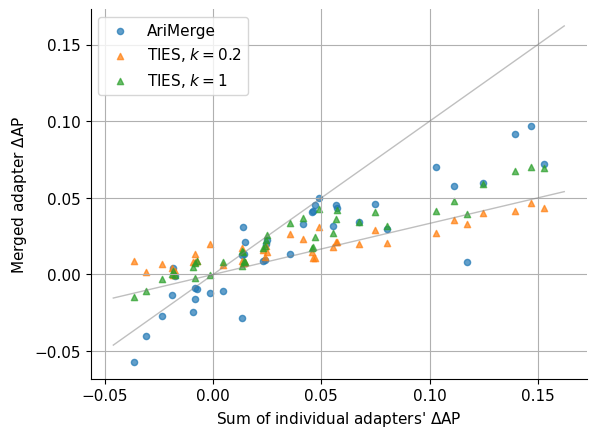

In [50]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()



linear = combos_df[combos_df.merge_method == 'linear']
ax.scatter(linear.summed_diff, linear.actual_diff, s=20, alpha=0.7, label='AriMerge')

ties = combos_df[(combos_df.merge_method == 'ties') & (combos_df.ties_density == 0.2)]
ax.scatter(ties.summed_diff, ties.actual_diff, marker='^', s=20, alpha=0.7, label='TIES, $k=0.2$')

#semi_ties = combos_df[(combos_df.merge_method == 'ties') & (combos_df.ties_density == 0.5)]
#ax.scatter(semi_ties.summed_diff, semi_ties.actual_diff, marker='^', s=20, alpha=0.7, label='TIES, $k$=0.5')

semi_ties = combos_df[(combos_df.merge_method == 'ties') & (combos_df.ties_density == 1)]
ax.scatter(semi_ties.summed_diff, semi_ties.actual_diff, marker='^', s=20, alpha=0.7, label='TIES, $k=1$')

ax.legend()

x_range = np.array(ax.get_xlim())
ax.plot(x_range, x_range, color='gray', alpha=0.5, lw=1)
ax.plot(x_range, x_range/3, color='gray', alpha=0.5, lw=1)


ax.set_ylabel(r'Merged adapter $\Delta$AP')
ax.set_xlabel(r"Sum of individual adapters' $\Delta$AP")

fig.savefig('../../report/latex/figures/adapter-combos.pdf')

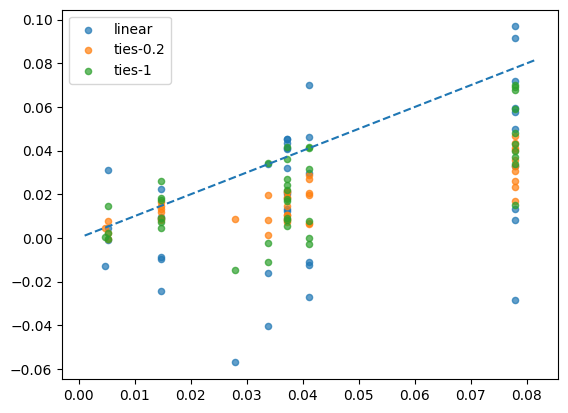

In [634]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

linear = combos_df[combos_df.merge_method == 'linear']
ax.scatter(linear.max_diff, linear.actual_diff, s=20, alpha=0.7, label='linear')

ties = combos_df[(combos_df.merge_method == 'ties') & (combos_df.ties_density == 0.2)]
ax.scatter(ties.max_diff, ties.actual_diff, s=20, alpha=0.7, label='ties-0.2')

semi_ties = combos_df[(combos_df.merge_method == 'ties') & (combos_df.ties_density == 1)]
ax.scatter(semi_ties.max_diff, semi_ties.actual_diff, s=20, alpha=0.7, label='ties-1')

x_range = ax.get_xlim()
ax.plot(x_range, x_range, '--')

ax.legend()

In [635]:
good_combos_linear = linear[linear.adapters_all_positive]
linear_beats_max = (good_combos_linear.average_precision > good_combos_linear.max_score).mean()

good_combos_ties = ties[ties.adapters_all_positive]
ties_beats_max = (good_combos_ties.average_precision > good_combos_ties.max_score).mean()

good_combos_semi_ties = semi_ties[semi_ties.adapters_all_positive]
semi_ties_beats_max = (good_combos_semi_ties.average_precision > good_combos_semi_ties.max_score).mean()

linear_beats_max, ties_beats_max, semi_ties_beats_max

(0.6, 0.15, 0.35)

In [439]:
good_combos = linear[linear.average_precision > linear.max_score].active_adapters_versioned
good_counts = Counter(apt for combo in good_combos for apt in combo)

bad_combos = linear[linear.average_precision <= linear.max_score].active_adapters_versioned
bad_counts = Counter(apt for combo in bad_combos for apt in combo)

Counter([tuple(gc) for gc in good_combos])

Counter({('model-lily-sm:v3',
          'model-daffodil-sm:v2',
          'model-bluebell-sm:v2'): 2,
         ('model-lily-sm:v3', 'model-poppy-sm:v2', 'model-bluebell-sm:v2'): 1,
         ('model-lily-sm:v3', 'model-daffodil-sm:v2', 'model-poppy-sm:v2'): 1,
         ('model-edelweiss-sm:v3',
          'model-lily-sm:v3',
          'model-bluebell-sm:v2'): 1,
         ('model-edelweiss-sm:v3',
          'model-lily-sm:v3',
          'model-daffodil-sm:v2'): 1,
         ('model-daffodil-sm:v2',
          'model-poppy-sm:v2',
          'model-bluebell-sm:v2'): 1,
         ('model-hyacinth-sm:v3',
          'model-poppy-sm:v2',
          'model-bluebell-sm:v2'): 1,
         ('model-hyacinth-sm:v3',
          'model-daffodil-sm:v2',
          'model-bluebell-sm:v2'): 1,
         ('model-hyacinth-sm:v3',
          'model-daffodil-sm:v2',
          'model-poppy-sm:v2'): 1,
         ('model-lily-sm:v3',
          'model-hyacinth-sm:v3',
          'model-bluebell-sm:v2'): 1,
         ('model-

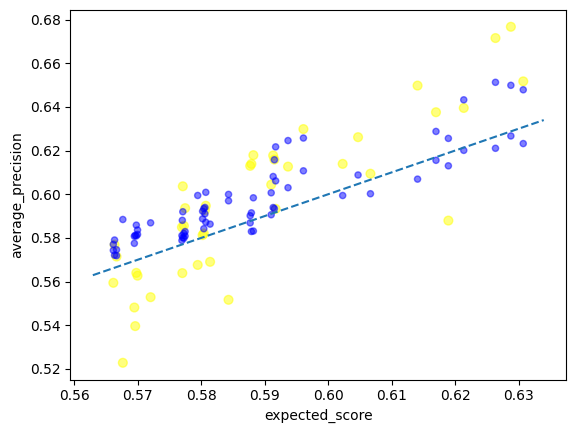

In [380]:
colors = combos_df.merge_method.apply(lambda mm: 'blue' if mm == 'ties' else 'yellow')
sizes = combos_df.merge_method.apply(lambda mm: 20 if mm == 'ties' else 40)
ax = combos_df.plot.scatter('expected_score', 'average_precision', c=colors, alpha=0.5, s=sizes)

x_range = ax.get_xlim()
ax.plot(x_range, x_range, '--')

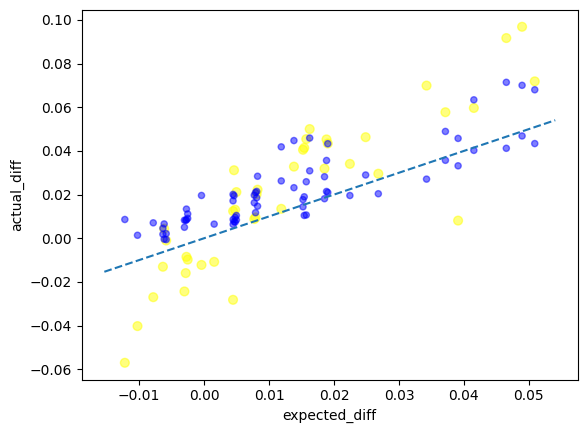

In [381]:
ax = combos_df.plot.scatter('expected_diff', 'actual_diff', c=colors, alpha=0.5, s=sizes)

x_range = ax.get_xlim()
ax.plot(x_range, x_range, '--')

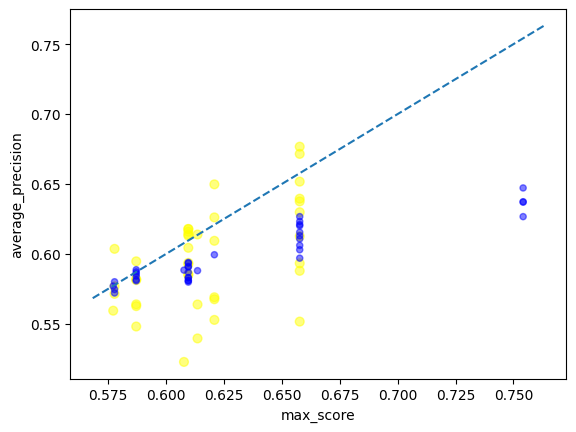

In [303]:
colors = combos_df.merge_method.apply(lambda mm: 'blue' if mm == 'ties' else 'yellow')
sizes = combos_df.merge_method.apply(lambda mm: 20 if mm == 'ties' else 40)
ax = combos_df.plot.scatter('max_score', 'average_precision', c=colors, alpha=0.5, s=sizes)

x_range = ax.get_xlim()
ax.plot(x_range, x_range, '--')

### Finding good weightings for few-shot adaptation

In [665]:
df = get_wandb_runs_table('tberm-org/few-shot-adapt-hp-tune')
df.columns

Index(['name', 'pos_rate', 'acc_bs_mean', 'Eval results/ncols',
       'Eval results/nrows', 'Eval results/sha256',
       'Eval results/artifact_path', 'Eval results/_latest_artifact_path',
       'Eval results/path', 'Eval results/size', 'Eval results/_type',
       'specificity@99', 'av_prec_bs_stdev', 'auroc', 'neg_recall',
       'f1_bs_stdev', 'precision@95', 'specificity@95', 'average_precision',
       'acc', 'acc_bs_stdev', 'precision@99', 'f1_bs_mean', 'recall',
       'precision', 'precision@98', 'specificity@98', 'av_prec_bs_mean', 'f1',
       'model', 'use_gpu', 'start_ts', 'run_config/eval_set',
       'run_config/num_shots', 'run_config/allow_pass',
       'run_config/batch_size', 'run_config/save_every',
       'run_config/example_ids', 'run_config/prompt_file',
       'run_config/results_dir', 'run_config/adapters_seed',
       'run_config/prompt_format', 'run_config/trunc_dataset',
       'run_config/load_multi_adapters', 'run_config/adapter_merge_method',
       'ru

In [669]:
mt_df['run_config/load_multi_adapters'][0]

{'tberm-org/multi-review-ft/model-hernandez:v3': 0.8,
 'file:///mnt/nfs/wandb/artifacts/fs-r8-seed-1/iris-fs-r8-final': 0.19999999999999996}

In [ ]:
mt_df = df[df.name.str.contains('mt')]
mod_df = df[df.name.str.contains('mod')]

In [683]:
mt_df['few_shot_weight'] = mt_df['run_config/load_multi_adapters'].apply(
    lambda adapters: [round(weight, 1) for apt, weight in adapters.items() if 'fs-' in apt][0]
)
mt_df['eval_review'] = mt_df['run_config/eval_set'].apply(get_review_from_eval_set)

for review in mt_df.eval_review.unique():
    rows = mt_df[mt_df.eval_review == review]
    print(review)
    print(rows.sort_values('average_precision')[['few_shot_weight', 'average_precision']])

378562
   few_shot_weight  average_precision
0              0.2           0.692730
2              0.8           0.695692
1              0.5           0.709198
334317
    few_shot_weight  average_precision
10              0.2           0.338416
9               0.5           0.357429
3               0.8           0.369332
287708
    few_shot_weight  average_precision
12              0.2           0.585934
4               0.8           0.603005
11              0.5           0.608773
258698
    few_shot_weight  average_precision
5               0.8           0.596814
14              0.2           0.647567
13              0.5           0.667432
165805
    few_shot_weight  average_precision
16              0.2           0.639735
6               0.8           0.645270
15              0.5           0.657820
121733
    few_shot_weight  average_precision
18              0.2           0.850832
17              0.5           0.863181
7               0.8           0.866617
117787
    few_shot_weight

/tmp/ipykernel_64868/373968037.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mt_df['few_shot_weight'] = mt_df['run_config/load_multi_adapters'].apply(
/tmp/ipykernel_64868/373968037.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mt_df['eval_review'] = mt_df['run_config/eval_set'].apply(get_review_from_eval_set)


In [684]:
mod_df['few_shot_weight'] = mod_df['run_config/load_multi_adapters'].apply(
    lambda adapters: [round(weight, 1) for apt, weight in adapters.items() if 'few-shot-' in apt][0]
)
mod_df['eval_review'] = mod_df['run_config/eval_set'].apply(get_review_from_eval_set)

for review in mod_df.eval_review.unique():
    rows = mod_df[mod_df.eval_review == review]
    print(review)
    print(rows.sort_values('average_precision')[['few_shot_weight', 'average_precision']])

378562
    few_shot_weight  average_precision
35              0.2           0.765305
21              0.8           0.766386
28              0.5           0.780458
334317
    few_shot_weight  average_precision
36              0.2           0.367461
29              0.5           0.380178
22              0.8           0.383284
287708
    few_shot_weight  average_precision
23              0.8           0.623909
30              0.5           0.636456
37              0.2           0.641940
258698
    few_shot_weight  average_precision
24              0.8           0.429775
31              0.5           0.469627
38              0.2           0.540756
165805
    few_shot_weight  average_precision
39              0.2           0.644057
32              0.5           0.658190
25              0.8           0.660628
121733
    few_shot_weight  average_precision
26              0.8           0.880052
40              0.2           0.883948
33              0.5           0.883950
117787
    few_shot_we

/tmp/ipykernel_64868/1825710382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_df['few_shot_weight'] = mod_df['run_config/load_multi_adapters'].apply(
/tmp/ipykernel_64868/1825710382.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_df['eval_review'] = mod_df['run_config/eval_set'].apply(get_review_from_eval_set)


In [688]:
api = wandb.Api()
runs  = api.runs('tberm-org/few-shot-adapt-hp-tune')


In [703]:
api = wandb.Api()
multi_review_ft = [run for run in api.runs('tberm-org/multi-review-ft')
                   if 'manual' not in run.tags and 'too-short' not in run.tags
                   and 'full' in run.config['run_config']['eval_set']]
                   


In [718]:
from nb_funcs import get_model_from_run

multi_review_df = make_df_from_wandb_runs(multi_review_ft)
models_to_runs = {}
for run in multi_review_ft:
    model = get_model_from_run(run)
    models_to_runs[model.name] = run.id

In [706]:
models_to_runs

{'model-bartra:v6': 'l5dr18o7',
 'model-carles:v6': 's3qu60te',
 'model-arbeloa:v5': 'ib9vuqls',
 'model-gavi:v5': '5di7n829',
 'model-carles:v5': 'gax2eke5',
 'model-carles:v3': 'b5ssg4nx',
 'model-diarra:v5': 'iy43zc2v',
 'model-hernandez:v5': '881mfzdb',
 'model-ferran:v5': 'x7yovtij',
 'model-gavi:v4': 'efdqtaj3',
 'model-hernandez:v3': 'z9b8edlq',
 'model-bartra:v5': '7wvxqyl1',
 'model-gavi:v3': 'nec7zd1y',
 'model-arbeloa:v4': '9v4kieou',
 'model-ferran:v3': 'ol1uwfmm',
 'model-bartra:v4': 'w0yg5vzf',
 'model-diarra:v3': 'nm7z3qzv',
 'model-arbeloa:v3': 'ikm6ew8i'}

In [736]:
def select_nat_few_shot(df, min_pos=5):
    few_shot_df = df.sample(50)
    pos_count = few_shot_df.label.sum()
    if pos_count >= min_pos:
        return few_shot_df
        
    pos_needed = min_pos - pos_count
    few_shot_df = pd.concat([
        few_shot_df.iloc[:-pos_needed],
        df[df.label == 1].sample(pos_needed),
    ]).sample(frac=1)
    return few_shot_df

In [741]:
bl_df

,name,acc,recall,neg_recall,precision,pos_rate,average_precision,auroc,eval_set
review,,,,,,,,,
258698,258,0.938269,0.753247,0.943916,0.290727,0.076731,0.579834,0.958245,data/covidence/review_258698/trunc_full.txt
121733,121,0.779730,0.438662,0.974522,0.907692,0.175676,0.819144,0.882308,data/covidence/review_121733/trunc_full.txt
378562,378,0.880249,0.479592,0.952294,0.643836,0.113530,0.612577,0.890695,data/covidence/review_378562/full.csv
334317,334,0.818328,0.777778,0.819533,0.113557,0.197709,0.282620,0.867489,data/covidence/review_334317/full.csv
288055,288,0.920348,0.307692,0.932103,0.080000,0.072411,0.124815,0.874340,data/covidence/review_288055/full.csv
287708,287,0.824265,0.546875,0.888587,0.532319,0.193382,0.572476,0.836313,data/covidence/review_287708/full.csv
165805,165,0.915358,0.380753,0.977594,0.664234,0.059773,0.549595,0.867273,data/covidence/review_165805/full.csv
117787,117,0.916541,0.394366,0.978956,0.691358,0.060902,0.564796,0.898519,data/covidence/review_117787/full.csv


In [737]:
from ast import literal_eval


hp_tune_run = mt_df.iloc[0]
adapters = hp_tune_run['run_config/load_multi_adapters']
mt_adapter = [apt for apt in adapters if 'multi-review-ft' in apt][0]
training_run_id = models_to_runs[mt_adapter.split('/')[-1]]
training_run = [run for run in multi_review_ft if run.id == training_run_id][0]
results_df = get_results_df_for_run(training_run)
few_shot_results_df = select_nat_few_shot(results_df)
few_shot_results_df['pos_prob'] = few_shot_results_df.label_probs.apply(lambda p: literal_eval(p)[1])
fs_metrics = compute_metrics(few_shot_results_df)


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.
wandb:   1 of 1 files downloaded.  


{'acc': 0.94,
 'precision': 0.7,
 'recall': 1.0,
 'f1': 0.8235294117647058,
 'neg_recall': 0.9302325581395349,
 'pos_rate': 0.2,
 'average_precision': 0.7916666666666665,
 'auroc': 0.9634551495016611,
 'specificity@95': 0.9302325581395349,
 'specificity@98': 0.9302325581395349,
 'specificity@99': 0.9302325581395349,
 'precision@95': 0.7,
 'precision@98': 0.7,
 'precision@99': 0.7}

#### Are fine-tuned models biased towards papers in their training review?

In [204]:
summary_cols = ['f1', 'acc', 'recall', 'neg_recall', 'precision', 'pos_rate', 'average_precision']
config_cols = {'run_config/eval_set': 'eval_set', 'run_config/load_wandb_model': 'trained_model'}

import re

runs_to_reviews = {
    'bluebell': 117787,
    'daffodil': 121733,
    'hyacinth': 258698,
    'edelweiss': 287708,
    'lily': 334317,
    'iris': 378562,
    'poppy': 165805
}

def get_review_from_model_name(model_name):
    match = re.search(r'/model-(\w+):v\d', model_name)
    run_name = match.groups()[0]
    return runs_to_reviews[run_name]
    
xeval_df = get_wandb_runs_table('tberm-org/cross-review-eval', config_cols, summary_cols)
xeval_df['train_review'] = xeval_df.trained_model.apply(get_review_from_model_name)
xeval_df['eval_review'] = xeval_df.eval_set.apply(get_review_from_eval_set)

In [212]:
train_review = 258698
criteria_review = 121733

zero_shot = baseline_df[baseline_df.eval_review == criteria_review].iloc[0]
print('Base model positive rate:', zero_shot.pos_rate)

trained = xeval_df[
    (xeval_df.train_review == train_review)
    & (xeval_df.eval_review == criteria_review)
]
print('Trained model positive rate:', trained.pos_rate.mean())

Base model positive rate: 0.14183123877917414
Trained model positive rate: 0.14542190305206462


#### For the two very similar papers, which ones does the train model get wrong versus the baseline?

In [242]:
train_review = 278807
eval_review = 288055

api = wandb.Api()
runs = api.runs('tberm-org/mismatched-review')
zero_shot_run = [run for run in runs if run.name == 'darwin'][0]
zero_shot_results = get_results_df_for_run(zero_shot_run)
trained_run = [run for run in runs if run.name == 'cervantes'][0]
trained_results = get_results_df_for_run(trained_run)

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [257]:
zero_shot_pos = zero_shot_results[zero_shot_results.predicted_label == 1]

In [256]:
trained_pos = trained_results[trained_results.predicted_label == 1]

In [271]:
eval_df = pd.read_csv('../data/covidence/review_287708/zero-shot-eval.csv', index_col=0)

In [288]:
eval_df.loc[zero_shot_pos.index]

,orig_index,title,abstract,label,review_id
index,,,,,
12,12,Public Health Aspects of Climate Change Adapta...,Climate change presents an unprecedented publi...,1,287708
24,24,Impact of extreme weather conditions on health...,Extreme weather events pose significant threat...,1,287708
96,71,Climate Change Adaptation Strategies Vary With...,Vietnam faces several adverse climatic stresse...,1,287708
180,155,Autonomous adaptation to global environmental ...,The growth of pen-urban areas is increasingly ...,1,287708
237,212,Sustainable adaptation for resolving climate d...,Purpose - Climate change is affecting people d...,1,287708
250,225,"Urban Climate Justice, Human Health, and Citiz...",Urban informal settlements or slums are among ...,1,287708
277,16,Cost Benefit/Fiffectiveness Analysis of Climat...,"Northern Punjab region of Pakistan, known as P...",0,287708


In [282]:
eval_df.loc[trained_pos.index]

,orig_index,title,abstract,label,review_id
index,,,,,
3,3,Health coping strategies of the people vulnera...,Background: Among the many challenges faced by...,1,287708
12,12,Public Health Aspects of Climate Change Adapta...,Climate change presents an unprecedented publi...,1,287708
17,17,"Who defines ""good"" climate change adaptation a...","Pacific Island Countries, despite significant ...",1,287708
51,26,"Individual, communal and institutional respons...","The relationship between ""coping"" and ""resilie...",1,287708
61,36,Pro-poor adaptation for the urban extreme poor...,Purpose The purpose of this paper is to examin...,1,287708
96,71,Climate Change Adaptation Strategies Vary With...,Vietnam faces several adverse climatic stresse...,1,287708
142,117,Building responsiveness to climate change thro...,"This article explores the drivers, benefits, a...",1,287708
163,138,Farmers' perspective towards climate change vu...,Pakistan has become a highly vulnerable countr...,1,287708
180,155,Autonomous adaptation to global environmental ...,The growth of pen-urban areas is increasingly ...,1,287708


In [289]:
print(eval_df.loc[61].abstract)

Purpose The purpose of this paper is to examine pro-poor urban asset adaptation to climate variability and change. It constructs a conceptual framework that explores the appropriate asset adaptation strategies for extreme poor households as well as the process of supporting these households and groups in accumulating these assets. Design/methodology/approach Qualitative data are obtained from life histories, key informant interviews (KIIs) and focus-group discussions (FGDs). These data are collected, coded and themed. Findings This research identifies that households among the urban extreme poor do their best to adapt to perceived climate changes; however, in the absence of savings, and access to credit and insurance, they are forced to adopt adverse coping strategies. Individual adaptation practices yield minimal results and are short lived and even harmful because the urban extreme poor are excluded from formal policies and institutions as they lack formal rights and entitlements. Fo

### Estimating uncertainty from validation set size

In [590]:
import wandb
api = wandb.Api()
runs = api.runs('tberm-org/one-offs')
run = [run for run in runs if run.name == 'full-eval'][0]

In [591]:
df = get_results_df_for_run(run)

wandb:   1 of 1 files downloaded.  


In [7]:
(df.label == df.predicted_label).mean()

0.7879687078500135

In [588]:
import pandas as pd
import numpy as np
import sys
from ast import literal_eval
sys.path.append('/home/tom/msc/diss/experiments')

from evaluate import compute_metrics

def bootstrap(df, size, balance=True):
    if balance:
        split_df = pd.concat([
            df[df.label == 1].sample(size//2, replace=True),
            df[df.label == 0].sample(size-size//2, replace=True),
        ])
    else:
        split_df = df.sample(size, replace=True)
        
    # NOTE the average precision will be technically wrong since we are not using the normed probs here!
    probs = split_df.label_probs.apply(literal_eval).to_list()
    split_df['pos_prob'] = np.array(probs)[:, 1]
    return split_df

#### Balanced

In [35]:
bal_results = []
sizes = (30, 60, 120, 240, 480, 1000, 2000)
for size in sizes:
    print(f'Bootstrapping samples of size {size}...')
    bstrap_results = []
    for i in range(1000):
        split = bootstrap(df, size, balance=True)
        bstrap_results.append(compute_metrics(split))

    ap_scores = np.array([run['average_precision'] for run in bstrap_results])
    bal_results.append({
        'mean': ap_scores.mean(),
        'std': ap_scores.std(),
    })

Bootstrapping samples of size 30...
Bootstrapping samples of size 60...
Bootstrapping samples of size 120...
Bootstrapping samples of size 240...
Bootstrapping samples of size 480...
Bootstrapping samples of size 1000...
Bootstrapping samples of size 2000...


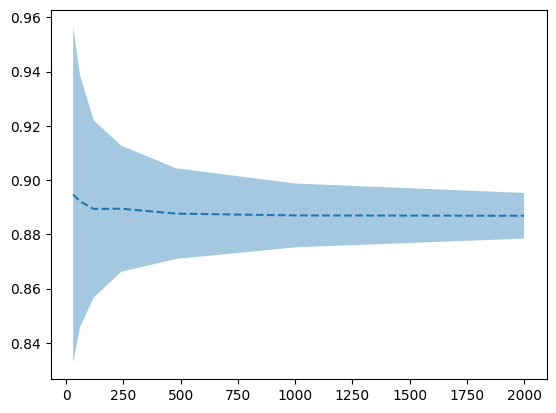

In [24]:
import matplotlib.pyplot as plt

high_line = [point['mean'] + point['std'] for point in results]
low_line = [point['mean'] - point['std'] for point in results]
mean = [point['mean'] for point in results]
fig, ax = plt.subplots()
ax.fill_between(sizes, low_line, high_line, alpha=0.4)
ax.plot(sizes, mean, '--')


#### Natural

In [594]:
nat_results

[{'mean': 0.8399964152835417, 'std': 0.0973882719075436},
 {'mean': 0.8391605094634176, 'std': 0.07380343294180383},
 {'mean': 0.8410829468220236, 'std': 0.04955219180495522},
 {'mean': 0.8331400431362324, 'std': 0.035661093496280556},
 {'mean': 0.8314282938403785, 'std': 0.026831321501849185},
 {'mean': 0.8327211078700171, 'std': 0.01828194450080841},
 {'mean': 0.8321825806554729, 'std': 0.013514495090740066}]

In [592]:
nat_results = []
sizes = (30, 60, 120, 240, 480, 1000, 2000)
for size in sizes:
    print(f'Bootstrapping samples of size {size}...')
    bstrap_results = []
    for i in range(1000):
        split = bootstrap(df, size, balance=False)
        bstrap_results.append(compute_metrics(split))

    ap_scores = np.array([run['average_precision'] for run in bstrap_results])
    nat_results.append({
        'mean': ap_scores.mean(),
        'std': ap_scores.std(),
    })

Bootstrapping samples of size 30...
Bootstrapping samples of size 60...
Bootstrapping samples of size 120...
Bootstrapping samples of size 240...
Bootstrapping samples of size 480...
Bootstrapping samples of size 1000...
Bootstrapping samples of size 2000...


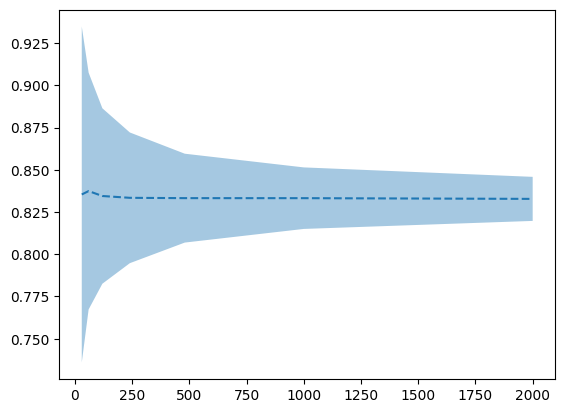

In [26]:
import matplotlib.pyplot as plt

high_line = [point['mean'] + point['std'] for point in nat_results]
low_line = [point['mean'] - point['std'] for point in nat_results]
mean = [point['mean'] for point in nat_results]
fig, ax = plt.subplots()
ax.fill_between(sizes, low_line, high_line, alpha=0.4)
ax.plot(sizes, mean, '--')

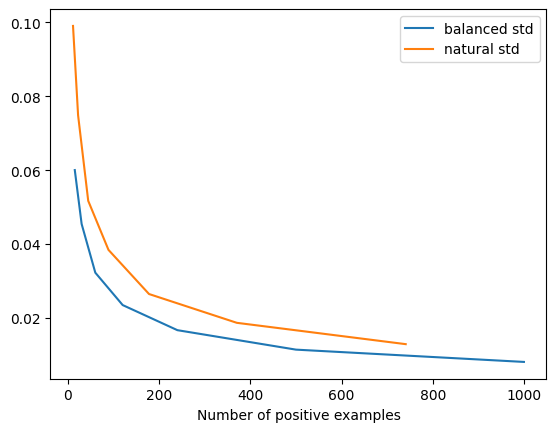

In [37]:
support = df.label.mean()
sizes = np.array(sizes)
pos_sample_size_bal = sizes / 2
pos_sample_size_nat = sizes * support
std_nat = [point['std'] for point in nat_results]
std_bal = [point['std'] for point in bal_results]

fig, ax = plt.subplots()
ax.plot(pos_sample_size_bal, std_bal, label='balanced std')
ax.plot(pos_sample_size_nat, std_nat, label='natural std')
ax.set_xlabel('Number of positive examples')
ax.legend()

In [40]:
std_nat

[0.09902893490111862,
 0.07487186155183663,
 0.05170768966237528,
 0.03843726852921541,
 0.026493835660264267,
 0.018701816933764825,
 0.012930022728238807]

In [46]:
bstrap_results = []
for i in range(1000):
    split = bootstrap(df, 400, balance=True)
    metrics = compute_metrics(split)
    bstrap_results.append(metrics['acc'])

bstrap_results = np.array(bstrap_results)
print('For balanced bootstraps:')
print('Mean:', bstrap_results.mean())
print('Std. dev:', bstrap_results.std())

support = df.label.mean()
bstrap_results = []
for i in range(1000):
    split = bootstrap(df, round(200 / support), balance=False)
    metrics = compute_metrics(split)
    bstrap_results.append(metrics['acc'])

bstrap_results = np.array(bstrap_results)
print('For natural bootstraps:')
print('Mean:', bstrap_results.mean())
print('Std. dev:', bstrap_results.std())
    

For balanced bootstraps:
Mean: 0.7978275000000001
Std. dev: 0.02021383174338799
For natural bootstraps:
Mean: 0.7872814814814815
Std. dev: 0.017398005341104722


In [64]:
api = wandb.Api()
runs = api.runs('tberm-org/ft-new-reviews')


In [81]:
runs_with_model = []
for run in runs:
    for art in run.logged_artifacts():
        if art.file_count > 4:
            print(art.name)
            runs_with_model.append(run)
            break

model-iris:v7
model-edelweiss:v12
model-lily:v6
model-hyacinth:v8
model-daffodil:v6
model-poppy:v6
model-bluebell:v7
model-iris:v6
model-lily:v5
model-daffodil:v5
model-hyacinth:v7
model-edelweiss:v9
model-poppy:v5
model-bluebell:v6
model-lily:v4
model-bluebell:v5
model-daffodil:v4
model-hyacinth:v6
model-iris:v5
model-edelweiss:v8
model-poppy:v4
model-hyacinth-cc:v1
model-edelweiss-cc:v1
model-poppy-cc:v1
model-lily-cc:v1
model-daffodil-cc:v1
model-iris-cc:v1
model-bluebell-cc:v1
model-euphorbia:v2
model-geranium:v5
model-amapola:v3
model-magnolia:v3
model-jasmine:v2
model-narcissus:v4
model-clematis:v4
model-lily-short:v1
model-foxglove:v1


In [82]:
from collections import defaultdict
from nb_funcs import get_review_from_eval_set

models_by_review = defaultdict(list)
for run in runs_with_model:
    if run.name.endswith('-cc'):
        continue
    review = get_review_from_eval_set(run.config['train_config']['train_set'])
    models_by_review[review].append(run)

In [85]:
relevant_runs = [run for group in models_by_review.values() for run in group]
runs_df = make_df_from_wandb_runs(relevant_runs)

### Why are results so different for different sample sizes?

In [28]:
import pandas as pd

api = wandb.Api()
# diarra evaluated on the whole of 258698
full_eval_art = api.artifact('tberm-org/one-offs/run-n2q2h8ng-Evalresults:v0')
table = full_eval_art.get('Eval results')
full_eval_df = pd.DataFrame(data=table.data, columns=table.columns).set_index('index')

part_eval_art = api.artifact('tberm-org/multi-review-ft/run-nm7z3qzv-Evalresults:v1')
table = part_eval_art.get('Eval results')
part_eval_df = pd.DataFrame(data=table.data, columns=table.columns).set_index('index')

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [40]:
from ast import literal_eval
part_eval_df['pos_prob'] = part_eval_df.label_probs.apply(lambda lis: literal_eval(lis)[1])
full_eval_df['pos_prob'] = full_eval_df.label_probs.apply(lambda lis: literal_eval(lis)[1])

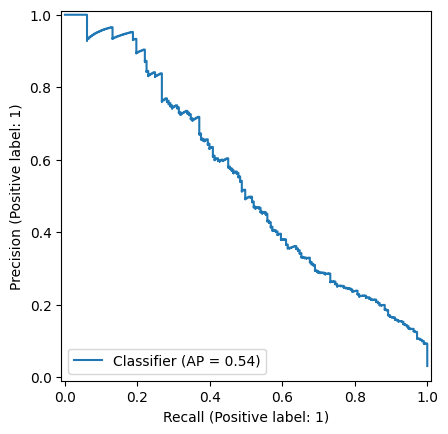

In [41]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(full_eval_df.label, full_eval_df.pos_prob)

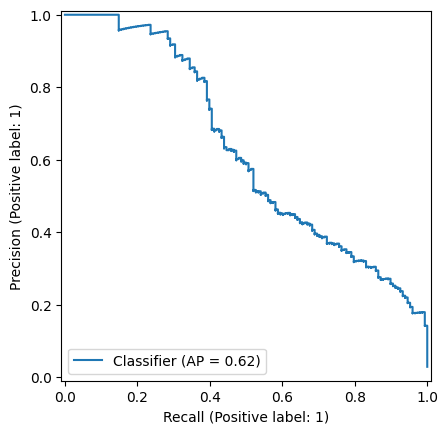

In [42]:
PrecisionRecallDisplay.from_predictions(part_eval_df.label, part_eval_df.pos_prob)

In [50]:
from sklearn.metrics import average_precision_score
import numpy as np

sizes = (2500, 2750, 3000, 3500, 4000, 4750, 5500, 6500)
results = []
for df_size in sizes:
    print(df_size)
    this_size_results = []
    for i in range(500):
        sample_df = full_eval_df.sample(df_size)
        this_size_results.append(
            average_precision_score(sample_df.label, sample_df.pos_prob)
        )
    this_size_results = np.array(this_size_results)
    results.append({
        'mean': this_size_results.mean(),
        'std': this_size_results.std(),
    })                   

2500
2750
3000
3500
4000
4750
5500
6500


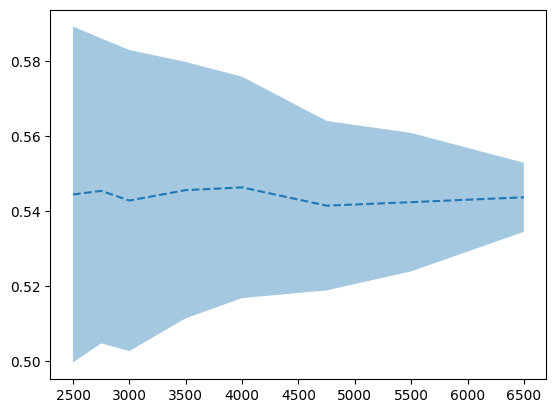

In [51]:
import matplotlib.pyplot as plt

high_line = [point['mean'] + point['std'] for point in results]
low_line = [point['mean'] - point['std'] for point in results]
mean = [point['mean'] for point in results]
fig, ax = plt.subplots()
ax.fill_between(sizes, low_line, high_line, alpha=0.4)
ax.plot(sizes, mean, '--')

In [56]:
scores = []
for i in range(1000):
    bs_df = bootstrap(full_eval_df, 6976, balance=False)
    scores.append(
        average_precision_score(bs_df.label, bs_df.pos_prob)
    )
scores = np.array(scores)
print('Mean:', scores.mean())
print('Stdev:', scores.std())

Mean: 0.5439028444969931
Stdev: 0.03377424510643903


### Final comparison of best approach with GPT

In [848]:
api = wandb.Api()
runs = api.runs('tberm-org/paper-sims-double-adapt')

runs = [
    run for run in runs if is_good_mt_run(run)
    and run.config['train_config']['seed'] == 1
]


dfs = []
for run in runs:
    results = get_results_df_for_run(run)
    review = get_review_from_eval_set(run.config['run_config']['eval_set'])
    results['review_id'] = review
    dfs.append(results)

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [926]:
api = wandb.Api()
runs = api.runs('tberm-org/multi-review-ft')

runs = [
    run for run in runs if is_good_mt_run(run)
]


zshot_dfs = []
reviews_seen = set()
for run in runs:
    review = get_review_from_eval_set(run.config['run_config']['eval_set'])
    if review in reviews_seen:
        continue
    reviews_seen.add(review)
    results = get_results_df_for_run(run)
    results['review_id'] = review
    zshot_dfs.append(results)

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [833]:
from run_common import init_config, load_dataset
init_config('gpt-eval')
eval_df = load_dataset('eval', return_df=True)

Using config from /home/tom/msc/diss/experiments/configs/gpt-eval.yaml
eval split has 455 items (98 positive)


In [849]:
all_preds = pd.concat(dfs)
all_preds['df_index'] = all_preds.index
all_preds = all_preds.set_index(['df_index', 'review_id'])

In [927]:
zshot_all_preds = pd.concat(zshot_dfs)
zshot_all_preds['df_index'] = zshot_all_preds.index
zshot_all_preds = zshot_all_preds.set_index(['df_index', 'review_id'])

In [870]:
dropped_idx = [(3628, 258698), (5954, 258698), (490, 258698), (898, 258698), (5084, 258698), (1854, 258698), (3052, 258698), (6261, 258698), (5173, 258698), (1201, 258698), (3819, 258698), (3503, 258698)]

In [871]:
eval_df = eval_df.drop(index=dropped_idx)

In [876]:
from ast import literal_eval

preds = all_preds.loc[eval_df.index]
preds['pos_prob'] = preds.label_probs.apply(lambda p: literal_eval(p)[1])


In [918]:
zshot_dropped_idx = [(1377, 121733), (2213, 121733), (1635, 121733), (1168, 121733), (1420, 121733), (1766, 121733), (3242, 121733), (3617, 121733), (1600, 121733), (1876, 121733), (459, 121733), (2735, 121733), (3760, 121733), (2719, 121733), (2782, 121733), (3104, 121733), (493, 121733), (3135, 121733), (2452, 121733), (3303, 121733), (987, 121733), (2871, 121733), (2165, 121733), (3583, 121733), (1212, 121733), (1980, 121733), (2747, 121733), (3768, 121733), (2392, 121733), (1063, 121733), (586, 121733), (2367, 121733), (867, 121733), (3818, 121733), (3544, 121733), (141, 121733), (3494, 121733), (808, 121733), (1720, 121733), (1650, 121733), (3606, 121733), (183, 121733), (3511, 121733), (157, 121733), (803, 121733), (3114, 121733), (1794, 121733), (2063, 121733), (647, 121733), (2772, 121733), (2988, 121733), (103, 121733), (2480, 121733), (920, 121733), (882, 121733), (1062, 121733)]

In [928]:
from ast import literal_eval

eval_df_adj = eval_df.drop(index=zshot_dropped_idx)
zshot_preds = zshot_all_preds.loc[eval_df_adj.index]
zshot_preds['pos_prob'] = zshot_preds.label_probs.apply(lambda p: literal_eval(p)[1])
len(zshot_preds)


387

In [877]:
compute_metrics(preds)

{'acc': 0.8623024830699775,
 'precision': 0.7228915662650602,
 'recall': 0.6122448979591837,
 'f1': 0.6629834254143647,
 'neg_recall': 0.9333333333333333,
 'pos_rate': 0.1873589164785553,
 'average_precision': 0.7347281315558418,
 'auroc': 0.886631174208814,
 'specificity@95': 0.42028985507246375,
 'specificity@98': 0.24927536231884062,
 'specificity@99': 0.23478260869565215,
 'precision@95': 0.3197278911564626,
 'precision@98': 0.27247191011235955,
 'precision@99': 0.27071823204419887}

In [867]:
df = pd.read_csv('../data/covidence/review_258698/full.csv', index_col=0)
df = df.loc[np.genfromtxt('../data/covidence/review_258698/nat_few_shot_complement.txt')]
df.loc[3628]

orig_index                                                 3406
title         Development of a phone survey tool to measure ...
abstract      Background: Respectful maternity care (RMC) is...
label                                                         0
review_id                                                258698
Name: 3628, dtype: object

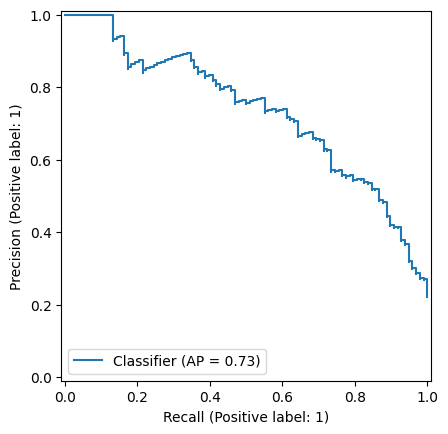

In [880]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

PrecisionRecallDisplay.from_predictions(preds.label, preds.pos_prob)

In [1]:
gpt_preds = pd.read_csv('../openai/gpt_final_preds.csv', index_col=0)

NameError: name 'pd' is not defined

In [2]:
gpt_preds['df_index'] = gpt_preds.index
gpt_preds = gpt_preds.set_index(['df_index', 'review_id'])

NameError: name 'gpt_preds' is not defined

({'acc': 0.8465011286681715,
  'precision': 0.6744186046511628,
  'recall': 0.5918367346938775,
  'f1': 0.6304347826086958,
  'neg_recall': 0.9188405797101449,
  'pos_rate': 0.19413092550790068,
  'average_precision': 0.6376468915599844,
  'auroc': 0.8641821946169772,
  'specificity@95': 0.0,
  'specificity@98': 0.0,
  'specificity@99': 0.0,
  'precision@95': 0.22121896162528218,
  'precision@98': 0.22121896162528218,
  'precision@99': 0.22121896162528218},
 {'acc': 0.8623024830699775,
  'precision': 0.7228915662650602,
  'recall': 0.6122448979591837,
  'f1': 0.6629834254143647,
  'neg_recall': 0.9333333333333333,
  'pos_rate': 0.1873589164785553,
  'average_precision': 0.7347281315558418,
  'auroc': 0.886631174208814,
  'specificity@95': 0.42028985507246375,
  'specificity@98': 0.24927536231884062,
  'specificity@99': 0.23478260869565215,
  'precision@95': 0.3197278911564626,
  'precision@98': 0.27247191011235955,
  'precision@99': 0.27071823204419887})

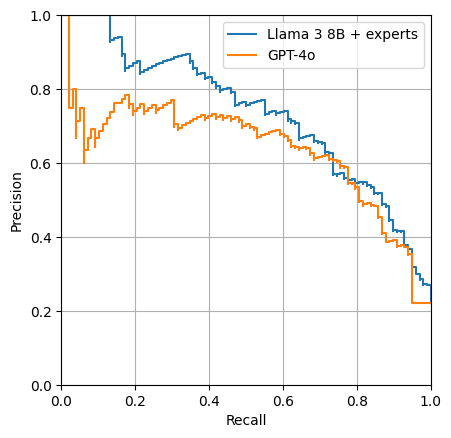

In [934]:
gpt_preds_adj = gpt_preds.drop(index=dropped_idx)

fig, ax = plt.subplots()

PrecisionRecallDisplay.from_predictions(preds.label, preds.pos_prob, ax=ax, label = 'Llama 3 8B + experts')
PrecisionRecallDisplay.from_predictions(gpt_preds_adj.label, gpt_preds_adj.yes_probability, ax=ax, label = 'GPT-4o')

ax.legend()

ax.grid(True)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_aspect('equal')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

#fig.savefig('../../report/latex/figures/pr_lines.pdf')

compute_metrics(gpt_preds_adj.rename(columns={'yes_probability': 'pos_prob'})), compute_metrics(preds) 

Text(0, 0.5, 'Precision')

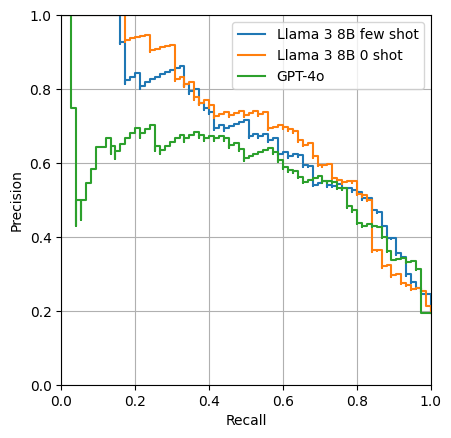

In [932]:
gpt_preds_adj = gpt_preds.drop(index=zshot_dropped_idx).drop(dropped_idx)

fig, ax = plt.subplots()

preds_dbl_adj = preds.drop(index=zshot_dropped_idx)
zshot_preds_dbl_adj = zshot_preds.drop(index=dropped_idx, errors='ignore')

PrecisionRecallDisplay.from_predictions(preds_dbl_adj.label, preds_dbl_adj.pos_prob, ax=ax, label = 'Llama 3 8B few shot')
PrecisionRecallDisplay.from_predictions(zshot_preds_dbl_adj.label, zshot_preds_dbl_adj.pos_prob, ax=ax, label = 'Llama 3 8B 0 shot')
PrecisionRecallDisplay.from_predictions(gpt_preds_adj.label, gpt_preds_adj.yes_probability, ax=ax, label = 'GPT-4o')

ax.legend()

ax.grid(True)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_aspect('equal')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

#fig.savefig('../../report/latex/figures/pr_lines.pdf')

In [7]:
import wandb
from ast import literal_eval

api = wandb.Api()
gpt_run = api.run('tberm-org/zero-shot-final/1jye0sm7')
gpt_eval_df = get_results_df_for_run(gpt_run)

wandb:   1 of 1 files downloaded.  


In [8]:
paper_sims_run = api.run('tberm-org/paper-sims-adapt/iuhjul0t')
ps_eval_df = get_results_df_for_run(paper_sims_run)
ps_eval_df['pos_prob'] = ps_eval_df.label_probs.apply(lambda p: literal_eval(p)[1])

wandb:   1 of 1 files downloaded.  


In [9]:
llama0_run = api.run('tberm-org/zero-shot-final/zy03mng3')
llama0_eval_df = get_results_df_for_run(llama0_run)
llama0_eval_df['pos_prob'] = llama0_eval_df.label_probs.apply(lambda p: literal_eval(p)[1])

wandb:   1 of 1 files downloaded.  


In [10]:
gpt_eval_df = gpt_eval_df.rename(columns={'yes_probability': 'pos_prob'})

In [11]:
gpt_eval_df.label.sum()

67

In [12]:
short_ps_eval_df = ps_eval_df.loc[gpt_eval_df.index]

In [18]:
import matplotlib as mpl
from cycler import cycler 

#mpl.rcParams['axes.prop_cycle'] = cycler(color=['#065143', '#93B7BE', '#EE8434'])
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['font.size'] = 11

In [14]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.matplotlib_fname()

'/home/tom/anaconda3/envs/diss/lib/python3.12/site-packages/matplotlib/mpl-data/matplotlibrc'

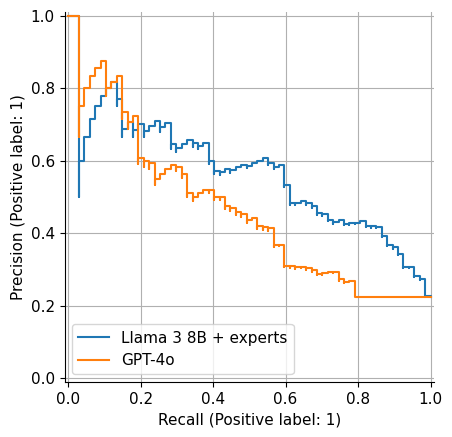

In [20]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(short_ps_eval_df.label, short_ps_eval_df.pos_prob, ax=ax, label = 'Llama 3 8B + experts')
PrecisionRecallDisplay.from_predictions(gpt_eval_df.label, gpt_eval_df.pos_prob, ax=ax, label = 'GPT-4o')
#PrecisionRecallDisplay.from_predictions(llama0_eval_df.label, llama0_eval_df.pos_prob, ax=ax, label = 'Llama 3 8B')

fig.savefig('../../report/latex/figures/pr_lines.pdf')

In [991]:
compute_metrics(short_ps_eval_df)

{'acc': 0.8133333333333334,
 'precision': 0.6410256410256411,
 'recall': 0.373134328358209,
 'f1': 0.4716981132075472,
 'neg_recall': 0.9399141630901288,
 'pos_rate': 0.13,
 'average_precision': 0.5654793929853237,
 'auroc': 0.8159631029402344,
 'specificity@95': 0.3819742489270386,
 'specificity@98': 0.24892703862660948,
 'specificity@99': 0.02145922746781115,
 'precision@95': 0.3076923076923077,
 'precision@98': 0.27385892116182575,
 'precision@99': 0.2271186440677966}

In [990]:
compute_metrics(gpt_eval_df)

{'acc': 0.7733333333333333,
 'precision': 0.4915254237288136,
 'recall': 0.43283582089552236,
 'f1': 0.46031746031746035,
 'neg_recall': 0.871244635193133,
 'pos_rate': 0.19666666666666666,
 'average_precision': 0.46511231727050534,
 'auroc': 0.6783678175645378,
 'specificity@95': 0.0,
 'specificity@98': 0.0,
 'specificity@99': 0.0,
 'precision@95': 0.22333333333333333,
 'precision@98': 0.22333333333333333,
 'precision@99': 0.22333333333333333}

In [982]:
precision, recall, _ = precision_recall_curve(gpt_eval_df.label, gpt_eval_df.pos_prob)

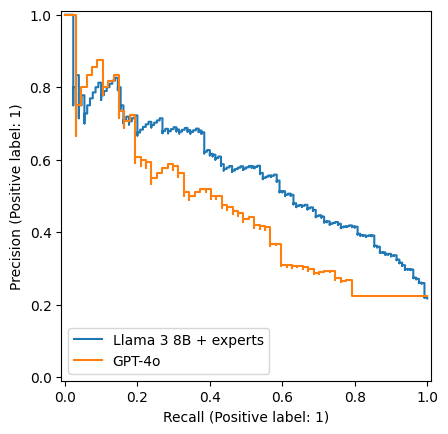

In [977]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(ps_eval_df.label, ps_eval_df.pos_prob, ax=ax, label = 'Llama 3 8B + experts')
PrecisionRecallDisplay.from_predictions(gpt_eval_df.label, gpt_eval_df.pos_prob, ax=ax, label = 'GPT-4o')